# Introduction

We need to set up the data loading function, which will involve many moving parts. I have generated networkx objects that can be read in but the code base for [U2GNN](https://github.com/daiquocnguyen/Graph-Transformer) does not take those, and instead takes in S2Vgraph objects 

## Installing Packages

Installing the relevant packages to the VM. From the repo, seems like we will need
* Python 3.x
* Tensorflow 1.14 & Tensor2tensor 1.13
* Pytorch >= 1.5.0
* Networkx 2.3
* Scikit-learn 0.21.2

In [1]:
!pip install -q --upgrade pip
!pip install -q torch==2.0.1
!pip install -q 'matplotlib<3.7'
!pip install -q scikit-spatial
!pip install -q networkx
!pip install -q scikit-learn
!pip install -q umap-learn

In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())

2.0.1+cu117
True
2.0.1+cu117
11.7
0
Tesla T4


## Importing Packages

In [3]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch_geometric
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
import pickle
import re
import scipy.sparse as sp
from sklearn.model_selection import StratifiedKFold
import umap.umap_ as umap
import csv

## Cloning github repo

In [4]:
home_dir = os.getcwd()

In [5]:
git_repo_dir = home_dir + '/u2gnn'
!rm -rf $git_repo_dir
!mkdir $git_repo_dir
!cd $git_repo_dir
!git clone https://github.com/daiquocnguyen/Graph-Transformer.git $git_repo_dir

Cloning into '/home/jupyter/complex_SVs/edit/u2gnn'...
remote: Enumerating objects: 700, done.
remote: Counting objects: 100% (485/485), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 700 (delta 273), reused 436 (delta 237), pack-reused 215
Receiving objects: 100% (700/700), 112.09 MiB | 36.51 MiB/s, done.
Resolving deltas: 100% (398/398), done.


[This issue](https://github.com/daiquocnguyen/Graph-Transformer/issues/8) says we have to make `LogUniformSampler` 

In [6]:
%%capture
os.chdir(home_dir)
# Compile the log uniform sampler
log_unif_dir = git_repo_dir + '/UGformerV1_PyTorch/log_uniform/'
os.chdir(log_unif_dir)
!make
os.chdir(home_dir)
# Set it in pythonpath
os.environ["PYTHONPATH"] = os.path.abspath(log_unif_dir) + ':' + \
    os.path.abspath(git_repo_dir + '/UGformerV1_PyTorch/') + ':' + \
    os.environ["PYTHONPATH"] 
os.environ["PYTHONPATH"] = re.sub(
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    os.environ["PYTHONPATH"]
)
os.environ["PATH"] = os.path.abspath(log_unif_dir) + ':' + \
    os.path.abspath(git_repo_dir + '/UGformerV1_PyTorch/') + ':' + \
    os.environ["PATH"]
os.environ["PATH"] = re.sub(
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    '/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform',
    os.environ["PATH"]
)

In [7]:
print(os.environ["PYTHONPATH"])
print(os.environ["PATH"])

/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch:/etc/jupyter/custom:/usr/lib/spark/python:/home/jupyter/packages
/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch/log_uniform:/home/jupyter/complex_SVs/edit/u2gnn/UGformerV1_PyTorch:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/jupyter/.local/bin:/home/jupyter/packages/bin


## Localizing data from the bucket

In [8]:
BILLING_PROJECT_ID = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET']

In [9]:
# Copy all files from the workspace bucket to the notebook disk
!gsutil -q cp -n $bucket/test_graphs/test.txt $home_dir

# Run list command to see if file is in the notebook disk
!readlink -m ./test.txt

/home/jupyter/complex_SVs/edit/test.txt


## Reading in graphs

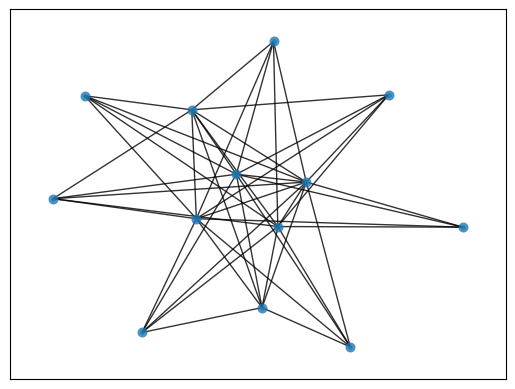

In [10]:
G = pickle.load(open("./test.txt", 'rb'))
nx.draw_networkx(
    G.subgraph([n for n in G.nodes if 'efe4d5dd-fffb-41df-ab86-be06cc16646f_19_' in n]), 
    node_size = 10, with_labels = False, alpha = 0.8, linewidths = 4
)

In [11]:
print('Features are:',list(G.nodes['efe4d5dd-fffb-41df-ab86-be06cc16646f_1_0'].keys()))

Features are: ['seqnames_breakend1_1', 'seqnames_breakend1_2', 'seqnames_breakend1_3', 'seqnames_breakend1_4', 'seqnames_breakend1_5', 'seqnames_breakend1_6', 'seqnames_breakend1_7', 'seqnames_breakend1_8', 'seqnames_breakend1_9', 'seqnames_breakend1_10', 'seqnames_breakend1_11', 'seqnames_breakend1_12', 'seqnames_breakend1_13', 'seqnames_breakend1_14', 'seqnames_breakend1_15', 'seqnames_breakend1_16', 'seqnames_breakend1_17', 'seqnames_breakend1_18', 'seqnames_breakend1_19', 'seqnames_breakend1_20', 'seqnames_breakend1_21', 'seqnames_breakend1_22', 'seqnames_breakend1_X', 'seqnames_breakend2_1', 'seqnames_breakend2_2', 'seqnames_breakend2_3', 'seqnames_breakend2_4', 'seqnames_breakend2_5', 'seqnames_breakend2_6', 'seqnames_breakend2_7', 'seqnames_breakend2_8', 'seqnames_breakend2_9', 'seqnames_breakend2_10', 'seqnames_breakend2_11', 'seqnames_breakend2_12', 'seqnames_breakend2_13', 'seqnames_breakend2_14', 'seqnames_breakend2_15', 'seqnames_breakend2_16', 'seqnames_breakend2_17', 'seq

# Convert Nx graph to S2VGraph

## S2VGraph Definition

In [12]:
"""Adapted from https://github.com/weihua916/powerful-gnns/blob/master/util.py"""

class S2VGraph(object):
    def __init__(self, g, label, node_tags=None, node_features=None):
        '''
            g: a networkx graph
            label: an integer graph label
            node_tags: a list of integer node tags
            node_features: a torch float tensor, one-hot representation of the tag that is used as input to neural nets
            edge_mat: a torch long tensor, contain edge list, will be used to create torch sparse tensor
            neighbors: list of neighbors (without self-loop)
        '''
        self.label = label
        self.g = g
        self.node_tags = node_tags
        self.neighbors = []
        self.node_features = 0
        self.edge_mat = 0
        self.max_neighbor = 0

## Loading Data Function

**Input for the load data function will be a list of strings indicating where the graphs are located on disk**

In [13]:
def create_s2v(graph_file):
    G = pickle.load(open(graph_file, 'rb'))
    graph_label = re.sub('_[0-9]*$','',list(G.nodes)[0])
    # relabel nodes to integer
    G = nx.relabel_nodes(G, {n: int(re.sub('.*_', '',n)) for n in G.nodes})
    # use fake label of 0 for everything
    return S2VGraph(G, label = 0), graph_label

def load_data_from_nx(graph_files):
    num_cores = multiprocessing.cpu_count()
    g_list, label_list = zip(*Parallel(n_jobs = num_cores)(
        delayed(create_s2v)(graph_file) for graph_file in graph_files if \
            pickle.load(open(graph_file, 'rb')).number_of_nodes() > 9 and
#             pickle.load(open(graph_file, 'rb')).number_of_nodes() <= 30 and
            pickle.load(open(graph_file, 'rb')).number_of_edges() > 0
    ))

    #add edge_mat and node_features     
    for g in g_list:
        # adding .neighbors
        g.neighbors = [[] for i in range(len(g.g))]
        for i, j in g.g.edges():
            g.neighbors[i].append(j)
            g.neighbors[j].append(i)
        degree_list = []
        for i in range(len(g.g)):
            g.neighbors[i] = g.neighbors[i]
            degree_list.append(len(g.neighbors[i]))
        # adding .max_neighbor
        g.max_neighbor = max(degree_list)

        #g.label = label_dict[g.label]

        # adding edge_mat
        edges = [list(pair) for pair in g.g.edges()]
        edges.extend([[i, j] for j, i in edges])
        g.edge_mat = np.transpose(np.array(edges, dtype=np.int32), (1,0))
        # deg_list = list(dict(g.g.degree(range(len(g.g)))).values())

        # node features
        
        # Include chromosome
        # g.node_features = np.array([
        #     np.array(list(g.g.nodes()[i].values()), dtype=np.float32) 
        #     for i in g.g.nodes()
        # ])
        
        # Exclude chromosomal information
        g.node_features = np.array([
            np.array(
                [v for k,v in g.g.nodes()[i].items() if not 'seqnames' in k], 
                dtype=np.float32
            ) 
            for i in g.g.nodes()
        ])
        
    return g_list, label_list

## Load S2VGraphs From the Bucket

In [14]:
# Copy all files from the workspace bucket to the notebook disk
graph_dir = home_dir + '/graphs'
!mkdir -p $graph_dir
!gsutil -q cp -n $bucket/nx_graphs/nx/* $graph_dir
!ls -l $graph_dir | wc -l
# input list of graph text files
nx_files = [
    graph_dir + '/' + f for f in os.listdir(graph_dir) if f.endswith('_nx_graph.txt')
]

14629


# Other Util Methods

In [15]:
"""Get indexes of train and test sets"""
def separate_data_idx(graph_list, fold_idx, seed=0):
    assert 0 <= fold_idx and fold_idx < 10, "fold_idx must be from 0 to 9."
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

    labels = [graph.label for graph in graph_list]
    idx_list = []
    for idx in skf.split(np.zeros(len(labels)), labels):
        idx_list.append(idx)
    train_idx, test_idx = idx_list[fold_idx]

    return train_idx, test_idx

In [16]:
"""Convert sparse matrix to tuple representation."""
def sparse_to_tuple(sparse_mx):
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

# Train Unsupervised Model

## Importing the necessary functions in the repo

In [17]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(123)

import numpy as np
np.random.seed(123)
import time

# ==================== ADDITIONAL CODE TO MAKE IMPORT WORK ====================
import sys 
import pyximport
sys.path.append(os.path.abspath(git_repo_dir+'/UGformerV1_PyTorch'))
sys.path.append(os.path.abspath(git_repo_dir+'/UGformerV1_PyTorch/log_uniform'))
# install from the log_uniform.pyx file. If not, the `import log_uniform` default to `log_uniform.*.so`
pyximport.install()
os.chdir('/home/jupyter/complex_SVs/edit')
os.chdir(git_repo_dir+'/UGformerV1_PyTorch')
# =============================================================================

from UGformerV1_UnSup import *
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from scipy.sparse import coo_matrix
from util import *
from sklearn.linear_model import LogisticRegression
import statistics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)

## Prep Args

In [18]:
os.chdir(git_repo_dir+'/UGformerV1_PyTorch')

import argparse
args = argparse.Namespace()
args.run_folder = '../'
args.dataset = 'custom'
args.learning_rate = 0.0005
args.batch_size = 16
args.num_epochs = 80
args.model_name = 'complexSV'
args.sampled_num = 512
args.dropout = 0.5
args.num_hidden_layers = 5
args.num_timesteps = 2
args.ff_hidden_size = 1024
args.num_neighbors = 8
args.fold_idx = 1

## Load data

In [19]:
# Load data
print("Loading data...")

use_degree_as_tag = False
    
graphs, labels = load_data_from_nx(nx_files)
print('length of graphs:',len(graphs))
num_classes = 1
graph_labels = np.array([graph.label for graph in graphs])
feature_dim_size = graphs[0].node_features.shape[1]
print(feature_dim_size)

Loading data...
length of graphs: 1008
44


Everything is now adapted from [code here](https://github.com/daiquocnguyen/Graph-Transformer/blob/master/UGformerV1_PyTorch/train_UGformerV1_UnSup.py#L148)

In [20]:
def get_Adj_matrix(batch_graph):
    edge_mat_list = []
    start_idx = [0]
    for i, graph in enumerate(batch_graph):
        start_idx.append(start_idx[i] + len(graph.g))
        edge_mat_list.append(graph.edge_mat + start_idx[i])

    Adj_block_idx = np.concatenate(edge_mat_list, 1)
    # Adj_block_elem = np.ones(Adj_block_idx.shape[1])

    Adj_block_idx_row = Adj_block_idx[0,:]
    Adj_block_idx_cl = Adj_block_idx[1,:]

    return Adj_block_idx_row, Adj_block_idx_cl

def get_graphpool(batch_graph):
    start_idx = [0]
    # compute the padded neighbor list
    for i, graph in enumerate(batch_graph):
        start_idx.append(start_idx[i] + len(graph.g))

    idx = []
    elem = []
    for i, graph in enumerate(batch_graph):
        elem.extend([1] * len(graph.g))
        idx.extend([[i, j] for j in range(start_idx[i], start_idx[i + 1], 1)])

    elem = torch.FloatTensor(elem)
    idx = torch.LongTensor(idx).transpose(0, 1)
    graph_pool = torch.sparse.FloatTensor(idx, elem, torch.Size([len(batch_graph), start_idx[-1]]))

    return graph_pool.to(device)

print('Beginning graph pool')
graph_pool = get_graphpool(graphs)
graph_indices = graph_pool._indices()[0]
vocab_size=graph_pool.size()[1]

def get_idx_nodes(selected_graph_idx):
    idx_nodes = [torch.where(graph_indices==i)[0] for i in selected_graph_idx]
    idx_nodes = torch.cat(idx_nodes)
    return idx_nodes.to(device)

def get_batch_data(selected_idx):
    batch_graph = [graphs[idx] for idx in selected_idx]

    X_concat = np.concatenate([graph.node_features for graph in batch_graph], 0)
    if "REDDIT" in args.dataset:
        X_concat = np.tile(X_concat, feature_dim_size) #[1,1,1,1]
        X_concat = X_concat * 0.01
    X_concat = torch.from_numpy(X_concat).to(device)

    Adj_block_idx_row, Adj_block_idx_cl = get_Adj_matrix(batch_graph)
    dict_Adj_block = {}
    for i in range(len(Adj_block_idx_row)):
        if Adj_block_idx_row[i] not in dict_Adj_block:
            dict_Adj_block[Adj_block_idx_row[i]] = []
        dict_Adj_block[Adj_block_idx_row[i]].append(Adj_block_idx_cl[i])

    input_neighbors = []
    for input_node in range(X_concat.shape[0]):
        if input_node in dict_Adj_block:
            input_neighbors.append([input_node] + list(np.random.choice(dict_Adj_block[input_node], args.num_neighbors, replace=True)))
        else:
            input_neighbors.append([input_node for _ in range(args.num_neighbors + 1)])
    input_x = np.array(input_neighbors)
    input_x = torch.transpose(torch.from_numpy(input_x), 0, 1).to(device)  # [seq_length, batch_size] for pytorch transformer, not [batch_size, seq_length]

    input_y = get_idx_nodes(selected_idx)

    return X_concat, input_x, input_y

print("Loading data... finished!")

Beginning graph pool
Loading data... finished!


## Model Setup

In [21]:
model = UGformerV1(feature_dim_size=feature_dim_size, ff_hidden_size=args.ff_hidden_size,
                        dropout=args.dropout, num_self_att_layers=args.num_timesteps,
                        vocab_size=vocab_size, sampled_num=args.sampled_num,
                        num_GNN_layers=args.num_hidden_layers, device=device).to(device) #Each UGformer layer consists of a number of self-attention layers

optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
num_batches_per_epoch = int((len(graphs) - 1) / args.batch_size) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_batches_per_epoch, gamma=0.1)

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    indices = np.arange(0, len(graphs))
    np.random.shuffle(indices)
    for start in range(0, len(graphs), args.batch_size):
        end = start + args.batch_size
        selected_idx = indices[start:end]
        X_concat, input_x, input_y = get_batch_data(selected_idx)
        optimizer.zero_grad()
        logits = model(X_concat, input_x, input_y)
        loss = torch.sum(logits)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

    return total_loss

## Debug training

In [22]:
indices = np.arange(0, len(graphs))
np.random.shuffle(indices)
start = 0
end = start + args.batch_size
selected_idx = indices[start:end]
X_concat, input_x, input_y = get_batch_data(selected_idx)
print(X_concat)
print(input_x)
print(input_y)
print(model.ugformer_layers[0](F.embedding(input_x, X_concat))[0])

tensor([[0.0000, 1.0000, 0.0000,  ..., 0.5103, 0.5107, 0.0000],
        [0.0000, 1.0000, 1.0000,  ..., 0.6879, 0.6866, 0.1267],
        [1.0000, 0.0000, 0.0000,  ..., 0.1701, 0.1074, 0.1267],
        ...,
        [1.0000, 0.0000, 0.0000,  ..., 0.5266, 0.5163, 0.2008],
        [0.0000, 1.0000, 0.0000,  ..., 0.4193, 0.3974, 0.2008],
        [0.0000, 1.0000, 0.0000,  ..., 0.1073, 0.1074, 0.0000]],
       device='cuda:0')
tensor([[  0,   1,   2,  ..., 458, 459, 460],
        [ 11,  10,   8,  ..., 446, 456, 446],
        [  2,   2,  13,  ..., 459, 456, 442],
        ...,
        [  2,  11,  13,  ..., 446, 457, 442],
        [ 17,  10,  15,  ..., 444, 458, 443],
        [ 10,  10,   8,  ..., 454, 456, 444]], device='cuda:0')
tensor([ 4385,  4386,  4387,  4388,  4389,  4390,  4391,  4392,  4393,  4394,
         4395,  4396,  4397,  4398,  4399,  4400,  4401,  4402, 28143, 28144,
        28145, 28146, 28147, 28148, 28149, 28150, 28151, 28152, 28153, 28154,
        28155, 28156, 28157, 28158, 2

## Training the model

In [23]:
"""main process"""
import os
out_dir = os.path.abspath(os.path.join(args.run_folder, "../runs_UGformerV2_UnSup", args.model_name))
print("Writing to {}\n".format(out_dir))
# Checkpoint directory
checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
write_acc = open(checkpoint_prefix + '_acc.txt', 'w')

cost_loss = []

for epoch in range(1, args.num_epochs + 1):
    epoch_start_time = time.time()
    train_loss = train()
    cost_loss.append(train_loss)
    # We don't have true labels, so we cannot run the evaluate function
    # mean_10folds, std_10folds = evaluate()
    # print('| epoch {:3d} | time: {:5.2f}s | loss {:5.2f} | mean {:5.2f} | std {:5.2f} | '.format(
                # epoch, (time.time() - epoch_start_time), train_loss, mean_10folds*100, std_10folds*100))

    print('| epoch {:3d} | time: {:5.2f}s | loss {:5.2f} | '.format(
            epoch, (time.time() - epoch_start_time), train_loss))

    if epoch > 5 and cost_loss[-1] > np.mean(cost_loss[-6:-1]):
        scheduler.step()

    write_acc.write('epoch ' + str(epoch) + '\n')

write_acc.close()

Writing to /home/jupyter/complex_SVs/edit/runs_UGformerV2_UnSup/complexSV

| epoch   1 | time: 20.87s | loss 340933.99 | 
| epoch   2 | time: 20.95s | loss 324953.45 | 
| epoch   3 | time: 20.78s | loss 321626.95 | 
| epoch   4 | time: 21.27s | loss 318538.83 | 
| epoch   5 | time: 20.80s | loss 316700.99 | 
| epoch   6 | time: 21.10s | loss 311612.45 | 
| epoch   7 | time: 22.06s | loss 306212.27 | 
| epoch   8 | time: 21.28s | loss 299968.11 | 
| epoch   9 | time: 20.85s | loss 292026.63 | 
| epoch  10 | time: 21.22s | loss 282600.35 | 
| epoch  11 | time: 21.01s | loss 275588.83 | 
| epoch  12 | time: 20.95s | loss 264819.09 | 
| epoch  13 | time: 20.91s | loss 253825.43 | 
| epoch  14 | time: 21.02s | loss 243764.74 | 
| epoch  15 | time: 20.84s | loss 234877.44 | 
| epoch  16 | time: 22.30s | loss 222330.42 | 
| epoch  17 | time: 20.92s | loss 210370.18 | 
| epoch  18 | time: 21.05s | loss 199240.50 | 
| epoch  19 | time: 21.00s | loss 185948.40 | 
| epoch  20 | time: 20.97s | los

## Save Outputs


In [24]:
# save models
!mkdir -p models
# save the model with the trained weights 
# include the hyperparameters in the filename
torch.save(
    model.state_dict(), 
    home_dir + '/models/' + 'UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '.pt'
)
print(
    'model saved to:',home_dir + '/models/' + 'UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '.pt'
)

model.eval() # Turn on the evaluation mode
with torch.no_grad():
    # evaluating
    node_embeddings = model.ss.weight
    graph_embeddings = torch.spmm(graph_pool, node_embeddings).data.cpu().numpy()
# save graph embeddings
graph_embeddings = pd.DataFrame(graph_embeddings)
graph_embeddings.index = labels
graph_embeddings.to_csv(home_dir + '/models/UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '_graph_embeddings.csv',
        index=True
)
print(
    'Graph embeddings saved to:',home_dir + '/models/UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '_graph_embeddings.csv'
)

# save graph pool variable
with open(home_dir + '/models/UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '_graph_pool.pkl', 'wb') as f:
    pickle.dump(graph_pool, f)

model saved to: /home/jupyter/complex_SVs/edit/models/UGformerV2_UnSup_lr0.0005_bs16_ep80_ff1024_nn8_sd512_do0.5_nl5_nt2.pt
Graph embeddings saved to: /home/jupyter/complex_SVs/edit/models/UGformerV2_UnSup_lr0.0005_bs16_ep80_ff1024_nn8_sd512_do0.5_nl5_nt2_graph_embeddings.csv


In [25]:
# recreate things to see if it works
graph_pool_saved = pickle.load(open(home_dir + '/models/UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '_graph_pool.pkl', 'rb'))
model_saved = UGformerV1(feature_dim_size=feature_dim_size, ff_hidden_size=args.ff_hidden_size,
                        dropout=args.dropout, num_self_att_layers=args.num_timesteps,
                        vocab_size=graph_pool_saved.size()[1], sampled_num=args.sampled_num,
                        num_GNN_layers=args.num_hidden_layers, device=device).to(device) #Each UGformer layer consists of a number of self-attention layers
model_saved.load_state_dict(torch.load(
    home_dir + '/models/' + 'UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '.pt'
))

model_saved.eval() # Turn on the evaluation mode
with torch.no_grad():
    # evaluating
    node_embeddings_saved = model_saved.ss.weight
    graph_embeddings_saved = torch.spmm(graph_pool_saved, node_embeddings_saved).data.cpu().numpy()

In [26]:
!gsutil -q cp -r -n $home_dir/models $bucket

## Visualization

In [27]:
model = UGformerV1(feature_dim_size=feature_dim_size, ff_hidden_size=args.ff_hidden_size,
                        dropout=args.dropout, num_self_att_layers=args.num_timesteps,
                        vocab_size=vocab_size, sampled_num=args.sampled_num,
                        num_GNN_layers=args.num_hidden_layers, device=device).to(device) #Each UGformer layer consists of a number of self-attention layers
model.load_state_dict(torch.load(
    home_dir + '/models/' + 'UGformerV2_UnSup_' + 'lr' + str(args.learning_rate) + \
        '_bs' + str(args.batch_size) + '_ep' + str(args.num_epochs) + \
        '_ff' + str(args.ff_hidden_size) + '_nn' + str(args.num_neighbors) + \
        '_sd' + str(args.sampled_num) + '_do' + str(args.dropout) + \
        '_nl' + str(args.num_hidden_layers) + '_nt' + str(args.num_timesteps) + '.pt'
))

model.eval() # Turn on the evaluation mode
with torch.no_grad():
    # evaluating
    node_embeddings = model.ss.weight
    graph_embeddings = torch.spmm(graph_pool, node_embeddings).data.cpu().numpy()

In [31]:
# UMAP dimensionality reduction
reducer = umap.UMAP(
    n_neighbors = 15, min_dist=0.1, n_components=2, n_epochs = 500
)
embedding = reducer.fit_transform(graph_embeddings)

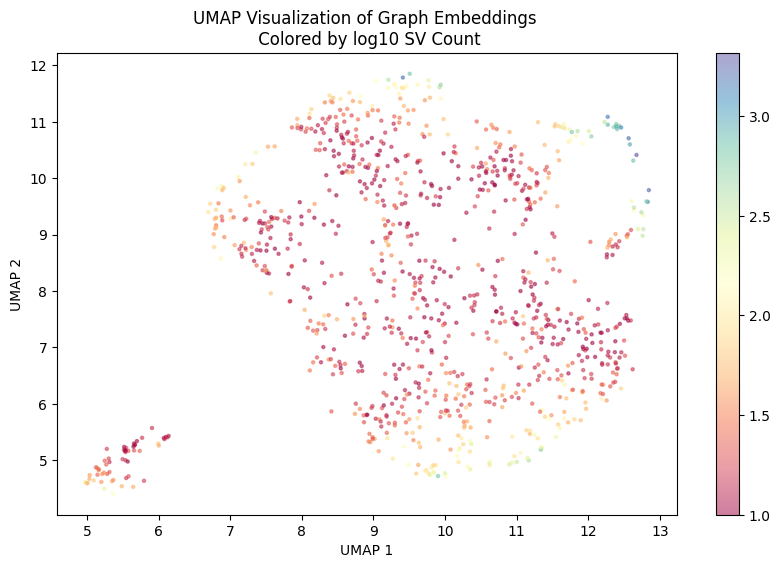

In [32]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=[np.log10(graph.g.number_of_nodes()) for graph in graphs], 
    cmap='Spectral', s=5, alpha = 0.5
)
plt.title('UMAP Visualization of Graph Embeddings \n Colored by log10 SV Count')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

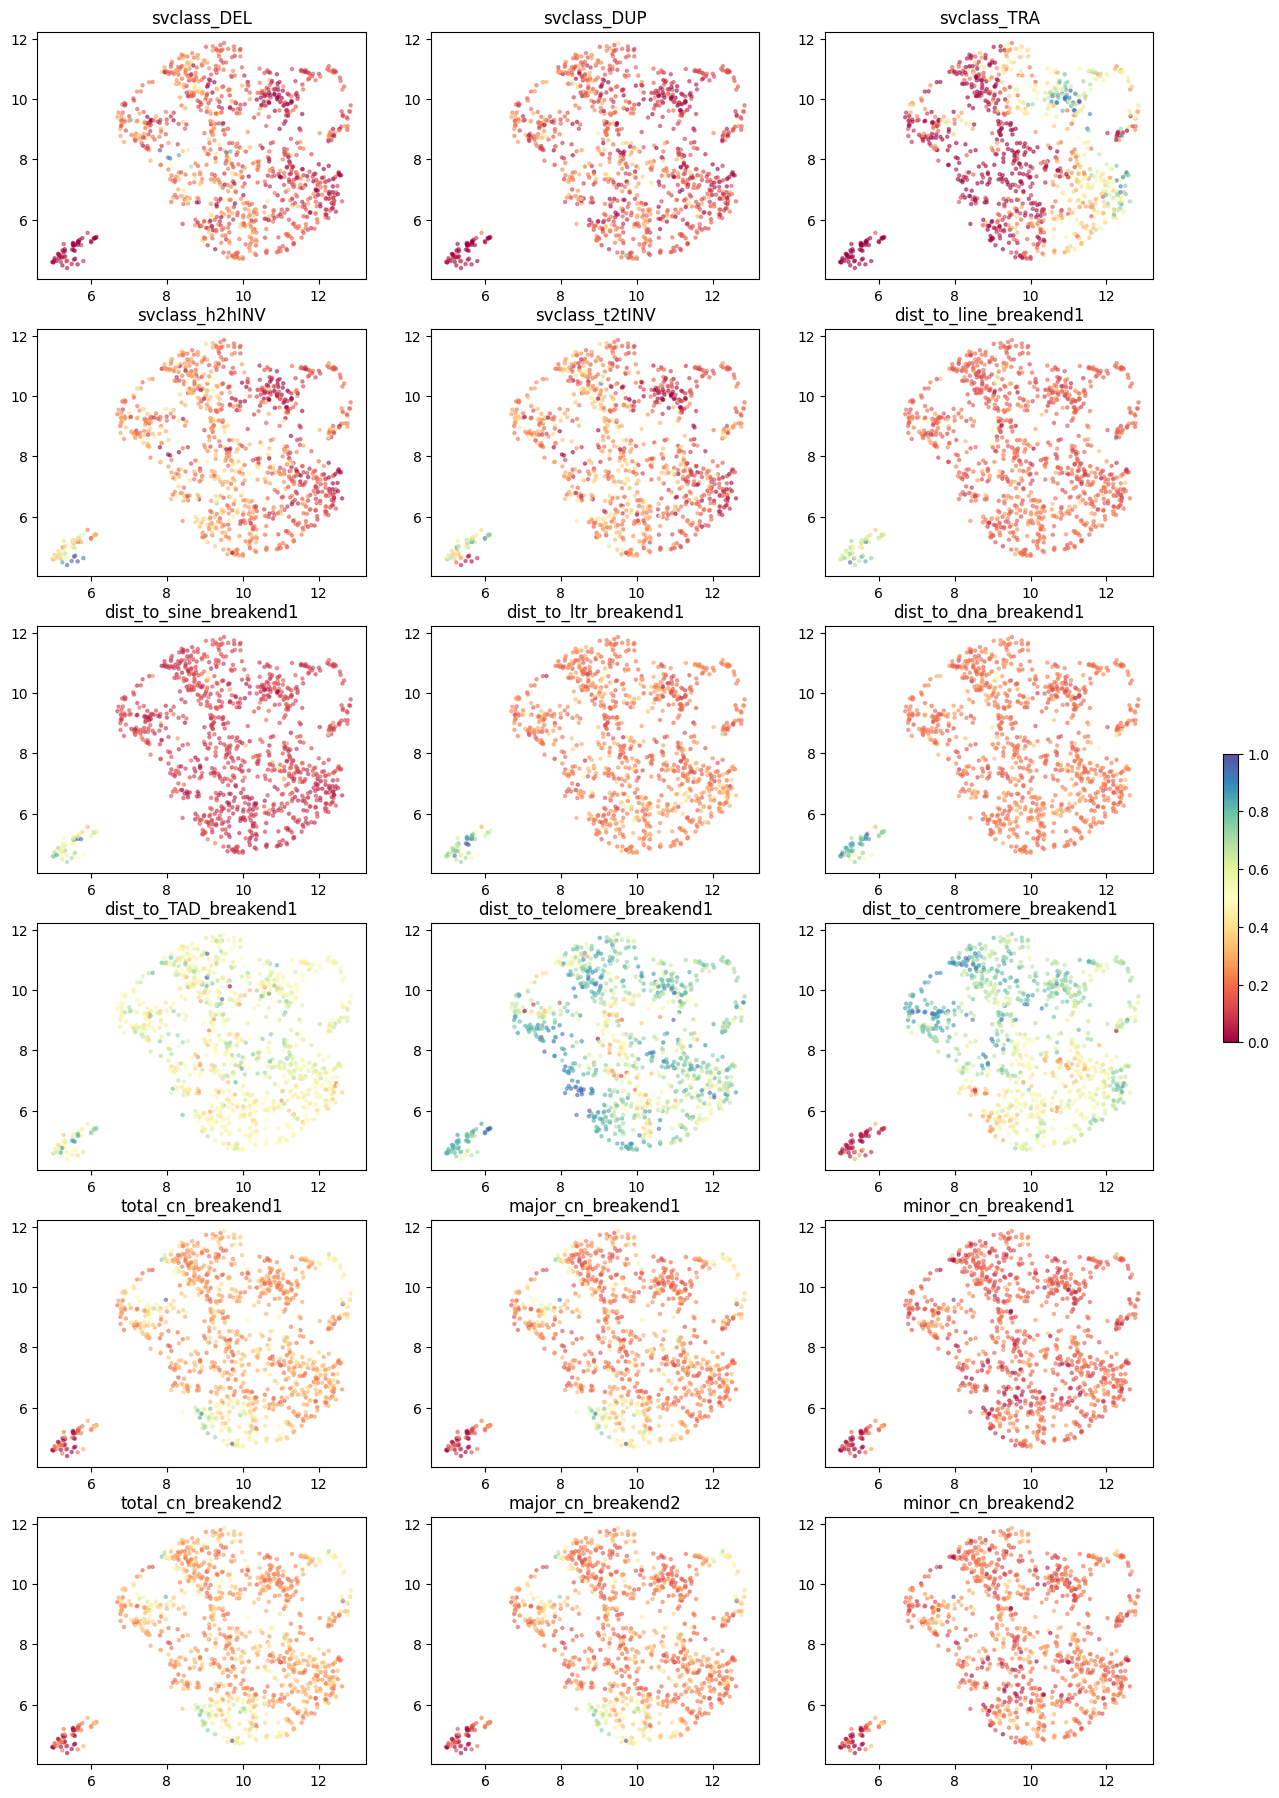

In [33]:
# Plotting
# 'cnt_type_breakend1_+', 'cnt_type_breakend1_-', 'cnt_type_breakend2_+', 'cnt_type_breakend2_-', 
# 'svclass_DEL', 'svclass_DUP', 'svclass_TRA', 'svclass_h2hINV', 'svclass_t2tINV', 
# 'start_breakend1', 'start_breakend2', 'ins_len', 'mh_len', 'N_ALT', 'N_ALT_RP', 'N_ALT_SR', 
# 'rep_time_breakend1', 'rep_time_breakend2', 'gc_breakend1', 'gc_breakend2', 
# 'gene_density_breakend1', 'gene_density_breakend2', 
# 'dist_to_line_breakend1', 'dist_to_line_breakend2', 'dist_to_sine_breakend1', 'dist_to_sine_breakend2', 
# 'dist_to_ltr_breakend1', 'dist_to_ltr_breakend2', 'dist_to_dna_breakend1', 'dist_to_dna_breakend2', 
# 'dist_to_sr_breakend1', 'dist_to_sr_breakend2', 'dist_to_TAD_breakend1', 'dist_to_TAD_breakend2', 
# 'dist_to_telomere_breakend1', 'dist_to_telomere_breakend2', 
# 'dist_to_centromere_breakend1', 'dist_to_centromere_breakend2', 
# 'total_cn_breakend1', 'major_cn_breakend1', 'minor_cn_breakend1', 
# 'total_cn_breakend2', 'major_cn_breakend2', 'minor_cn_breakend2'
feature_names = [
    'svclass_DEL', 'svclass_DUP','svclass_TRA', 'svclass_h2hINV', 'svclass_t2tINV',
    'dist_to_line_breakend1','dist_to_sine_breakend1','dist_to_ltr_breakend1','dist_to_dna_breakend1',
    'dist_to_TAD_breakend1', 'dist_to_telomere_breakend1', 'dist_to_centromere_breakend1',
    'total_cn_breakend1', 'major_cn_breakend1', 'minor_cn_breakend1',
    'total_cn_breakend2', 'major_cn_breakend2', 'minor_cn_breakend2'
    
]
fig, axs = plt.subplots(
    math.ceil(len(feature_names) / 3), 3,
    figsize=(18, math.ceil(len(feature_names) / 2) * 2.5)
)
# need to adjust for the fact that there are three columns
for i, feat_name in enumerate(feature_names):
    axs[i//3,i % 3].scatter(
        embedding[:, 0], embedding[:, 1], 
        c=[
            sum(nx.get_node_attributes(graph.g, feat_name).values()) / graph.g.number_of_nodes()
#             np.std(list(nx.get_node_attributes(graph.g, feat_name).values()))
            for graph in graphs
        ], 
        cmap='Spectral', s=5, alpha = 0.5
    )
    axs[i//3,i % 3].set_title(feat_name)
# colorbar for each panel
fig.colorbar(
    plt.cm.ScalarMappable(
        norm=plt.Normalize(0, 1), cmap='Spectral'
    ), ax=axs, orientation='vertical',
    shrink = 1/math.ceil(len(feature_names) / 3)
)
plt.show()